# Data Processing Workshop 
Author: Buz Galbraith (buzgalbraith@gmail.com)

## Import packages and set some variables for later

In [33]:
import pydicom
import os 
import numpy as np 
import polars as pl 
import datetime
import copy
import matplotlib.pyplot as plt
import pydicom.pixels
from pydicom import examples

os.environ["DICOM_DATASET"] = 'dicom_example/'
os.environ["PROCESSED_DATA_DIR"] = 'processed_data' 



## Motivation: The DICOM Standard
### here is the header

In [2]:
path = examples._get_path("jpeg2k")
header = pydicom.dcmread(path)
header

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 196
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Ultrasound Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.1.1.13.1.2.20040826185059.5457
(0002,0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.2
(0002,0013) Implementation Version Name         SH: 'DCTOOL100'
(0002,0016) Source Application Entity Title     AE: 'CLUNIE1'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'SMALL PARTS']
(0008,0012) Instance Creation Date              DA: '20040826'
(0008,0013) Instance Creation Time              TM: '185840'
(0008,0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.3
(0008,0016) SOP Class UID

### lets look at the image its self 

the pixel data is stored as <class 'bytes'>
the pixel data is stored as <class 'numpy.ndarray'>


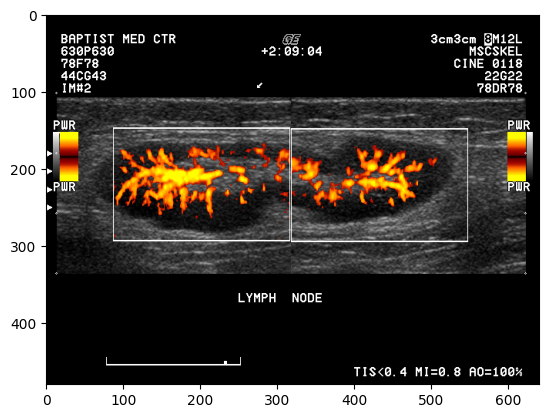

In [3]:
pd = header.PixelData
pd_array = pydicom.pixels.pixel_array(header, decoding_plugin='pillow')
print(f'the pixel data is stored as {type(pd)}')
print(f'the pixel data is stored as {type(pd_array)}')
plt.imshow(pd_array, cmap='gray')

## Case Study: Data Extraction
### use bash to get a list of all files in the dataset, and write them to a table of contents file.

In [4]:
! find $DICOM_DATASET -type 'f' > $PROCESSED_DATA_DIR/cohort/toc.txt

### lets load in the table of contents and look at our dataset.

In [34]:
toc = pl.read_csv(
    os.path.join(os.environ["PROCESSED_DATA_DIR"], 'cohort', 'toc.txt'),
    has_header=False, new_columns=['relative_path']
    )
toc.head()

relative_path
str
"""dicom_example/98892003/MR1/491…"
"""dicom_example/98892003/MR1/158…"
"""dicom_example/98892003/MR1/564…"
"""dicom_example/98892003/MR700/4…"
"""dicom_example/98892003/MR700/4…"


### Extract data from those DICOM files.

In [6]:
dicom_fields = ['PatientName', 'PatientID', 'AccessionNumber', 'StudyDate', 'Modality', 'StudyDescription', 'PatientSex', 'PatientAge', 'PatientWeight', 'ImageOrientationPatient']

### now lets extract the relevant fields from our metadata values

In [7]:
def safe_retrive(dicom_object, key):
    try:
        value = dicom_object[key].value
        if isinstance(value, pydicom.multival.MultiValue):
            return list(value)
        elif isinstance(value, pydicom.valuerep.PersonName):
            return str(value)
        else:
            return value
    except:
        return None

def get_dicom_fields(f_name:str, dicom_fields:list):
    """reads in a dicom file, and returns a dictionary with the requested metadata extracted from that file."""
    header = pydicom.dcmread(f_name)
    dicom_dict = {
        field_name : safe_retrive( header, field_name) for field_name in dicom_fields
    }
    
    dicom_dict['relative_path'] = f_name
    return dicom_dict


In [8]:
meta_rows = []
for f_name in toc.iter_rows():
    meta_rows.append(get_dicom_fields(f_name=f_name[0], dicom_fields=dicom_fields))
meta = pl.from_dicts(meta_rows)
meta

PatientName,PatientID,AccessionNumber,StudyDate,Modality,StudyDescription,PatientSex,PatientAge,PatientWeight,ImageOrientationPatient,relative_path
str,str,str,str,str,str,str,str,f64,list[f64],str
"""Doe^Peter""","""98890234""","""134""","""20030505""","""MR""","""Brain""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/491…"
"""Doe^Peter""","""98890234""","""428""","""20030505""","""MR""","""Carotids""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/158…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/564…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.414374, 0.910111, … -1.0]","""dicom_example/98892003/MR700/4…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.840635, 0.54161, … -1.0]","""dicom_example/98892003/MR700/4…"
…,…,…,…,…,…,…,…,…,…,…
"""Citizen^Jan""","""12345678""","""1""","""20200913""","""CT""","""Testing File-set""",null,null,null,null,"""dicom_example/TINY_ALPHA/PT000…"
"""Citizen^Jan""","""12345678""","""1""","""20200913""","""CT""","""Testing File-set""",null,null,null,null,"""dicom_example/TINY_ALPHA/PT000…"
"""Citizen^Jan""","""12345678""","""1""","""20200913""","""CT""","""Testing File-set""",null,null,null,null,"""dicom_example/TINY_ALPHA/PT000…"


### lets take a look at our dataset to see what we are dealing with 

In [9]:
meta.describe()

statistic,PatientName,PatientID,AccessionNumber,StudyDate,Modality,StudyDescription,PatientSex,PatientAge,PatientWeight,ImageOrientationPatient,relative_path
str,str,str,str,str,str,str,str,str,f64,f64,str
"""count""","""81""","""81""","""81""","""81""","""81""","""81""","""31""","""31""",17.0,28.0,"""81"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""50""","""50""",64.0,53.0,"""0"""
"""mean""",null,null,null,null,null,null,null,null,81.6327,null,null
"""std""",null,null,null,null,null,null,null,null,0.0,null,null
"""min""","""Citizen^Jan""","""12345678""","""1""","""19950903""","""CR""","""""","""""","""042Y""",81.6327,null,"""dicom_example/77654033/CR1/615…"
"""25%""",null,null,null,null,null,null,null,null,81.6327,null,null
"""50%""",null,null,null,null,null,null,null,null,81.6327,null,null
"""75%""",null,null,null,null,null,null,null,null,81.6327,null,null
"""max""","""Doe^Peter""","""98890234""","""428""","""20200913""","""MR""","""XR C Spine Comp Min 4 Views""","""M""","""047Y""",81.6327,null,"""dicom_example/TINY_ALPHA/PT000…"


In [10]:
print(meta.group_by("Modality").len())
print(meta.group_by("PatientName").len())
print(meta.group_by("StudyDescription").len())


shape: (3, 2)
┌──────────┬─────┐
│ Modality ┆ len │
│ ---      ┆ --- │
│ str      ┆ u32 │
╞══════════╪═════╡
│ CR       ┆ 3   │
│ CT       ┆ 61  │
│ MR       ┆ 17  │
└──────────┴─────┘
shape: (3, 2)
┌───────────────┬─────┐
│ PatientName   ┆ len │
│ ---           ┆ --- │
│ str           ┆ u32 │
╞═══════════════╪═════╡
│ Doe^Archibald ┆ 7   │
│ Citizen^Jan   ┆ 50  │
│ Doe^Peter     ┆ 24  │
└───────────────┴─────┘
shape: (7, 2)
┌─────────────────────────────┬─────┐
│ StudyDescription            ┆ len │
│ ---                         ┆ --- │
│ str                         ┆ u32 │
╞═════════════════════════════╪═════╡
│ XR C Spine Comp Min 4 Views ┆ 3   │
│                             ┆ 7   │
│ CT, HEAD/BRAIN WO CONTRAST  ┆ 4   │
│ Testing File-set            ┆ 50  │
│ Brain-MRA                   ┆ 11  │
│ Carotids                    ┆ 2   │
│ Brain                       ┆ 4   │
└─────────────────────────────┴─────┘


## Case Study: Processing Iteration One
### We first want to add a column with the absolute path to each directory

In [11]:
meta = meta.with_columns(
        absolute_dir = os.getcwd()+ '/' + pl.col('relative_path')
    )
meta.head() 

PatientName,PatientID,AccessionNumber,StudyDate,Modality,StudyDescription,PatientSex,PatientAge,PatientWeight,ImageOrientationPatient,relative_path,absolute_dir
str,str,str,str,str,str,str,str,f64,list[f64],str,str
"""Doe^Peter""","""98890234""","""134""","""20030505""","""MR""","""Brain""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/491…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""428""","""20030505""","""MR""","""Carotids""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/158…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/564…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.414374, 0.910111, … -1.0]","""dicom_example/98892003/MR700/4…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.840635, 0.54161, … -1.0]","""dicom_example/98892003/MR700/4…","""/home/buzgalbraith/workspace/d…"


### now lets filter for rows that, that have the patient name Citizen^Jan  

In [12]:
meta = meta.filter(~pl.col('PatientName').eq('Citizen^Jan'))
meta.head()

PatientName,PatientID,AccessionNumber,StudyDate,Modality,StudyDescription,PatientSex,PatientAge,PatientWeight,ImageOrientationPatient,relative_path,absolute_dir
str,str,str,str,str,str,str,str,f64,list[f64],str,str
"""Doe^Peter""","""98890234""","""134""","""20030505""","""MR""","""Brain""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/491…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""428""","""20030505""","""MR""","""Carotids""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/158…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/564…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.414374, 0.910111, … -1.0]","""dicom_example/98892003/MR700/4…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.840635, 0.54161, … -1.0]","""dicom_example/98892003/MR700/4…","""/home/buzgalbraith/workspace/d…"


### lets look out how that changed our dataset statistics

In [13]:
meta.describe()

statistic,PatientName,PatientID,AccessionNumber,StudyDate,Modality,StudyDescription,PatientSex,PatientAge,PatientWeight,ImageOrientationPatient,relative_path,absolute_dir
str,str,str,str,str,str,str,str,str,f64,f64,str,str
"""count""","""31""","""31""","""31""","""31""","""31""","""31""","""31""","""31""",17.0,28.0,"""31""","""31"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",14.0,3.0,"""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,81.6327,null,null,null
"""std""",null,null,null,null,null,null,null,null,0.0,null,null,null
"""min""","""Doe^Archibald""","""77654033""","""134""","""19950903""","""CR""","""""","""""","""042Y""",81.6327,null,"""dicom_example/77654033/CR1/615…","""/home/buzgalbraith/workspace/d…"
"""25%""",null,null,null,null,null,null,null,null,81.6327,null,null,null
"""50%""",null,null,null,null,null,null,null,null,81.6327,null,null,null
"""75%""",null,null,null,null,null,null,null,null,81.6327,null,null,null
"""max""","""Doe^Peter""","""98890234""","""428""","""20030505""","""MR""","""XR C Spine Comp Min 4 Views""","""M""","""047Y""",81.6327,null,"""dicom_example/98892003/MR700/4…","""/home/buzgalbraith/workspace/d…"


In [14]:
print(meta.group_by("Modality").len())
print(meta.group_by("PatientName").len())
print(meta.group_by("StudyDescription").len())

shape: (3, 2)
┌──────────┬─────┐
│ Modality ┆ len │
│ ---      ┆ --- │
│ str      ┆ u32 │
╞══════════╪═════╡
│ MR       ┆ 17  │
│ CR       ┆ 3   │
│ CT       ┆ 11  │
└──────────┴─────┘
shape: (2, 2)
┌───────────────┬─────┐
│ PatientName   ┆ len │
│ ---           ┆ --- │
│ str           ┆ u32 │
╞═══════════════╪═════╡
│ Doe^Peter     ┆ 24  │
│ Doe^Archibald ┆ 7   │
└───────────────┴─────┘
shape: (6, 2)
┌─────────────────────────────┬─────┐
│ StudyDescription            ┆ len │
│ ---                         ┆ --- │
│ str                         ┆ u32 │
╞═════════════════════════════╪═════╡
│ CT, HEAD/BRAIN WO CONTRAST  ┆ 4   │
│                             ┆ 7   │
│ Brain                       ┆ 4   │
│ XR C Spine Comp Min 4 Views ┆ 3   │
│ Carotids                    ┆ 2   │
│ Brain-MRA                   ┆ 11  │
└─────────────────────────────┴─────┘


## Case Study: Processing Iteration Two
### Lets filter the data the for only MRI and CAT scans. 

In [15]:
meta = meta.filter(~pl.col('Modality').eq('CR'))
meta.head()

PatientName,PatientID,AccessionNumber,StudyDate,Modality,StudyDescription,PatientSex,PatientAge,PatientWeight,ImageOrientationPatient,relative_path,absolute_dir
str,str,str,str,str,str,str,str,f64,list[f64],str,str
"""Doe^Peter""","""98890234""","""134""","""20030505""","""MR""","""Brain""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/491…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""428""","""20030505""","""MR""","""Carotids""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/158…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.0, 1.0, … -1.0]","""dicom_example/98892003/MR1/564…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.414374, 0.910111, … -1.0]","""dicom_example/98892003/MR700/4…","""/home/buzgalbraith/workspace/d…"
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[0.840635, 0.54161, … -1.0]","""dicom_example/98892003/MR700/4…","""/home/buzgalbraith/workspace/d…"


In [16]:
meta.describe()

statistic,PatientName,PatientID,AccessionNumber,StudyDate,Modality,StudyDescription,PatientSex,PatientAge,PatientWeight,ImageOrientationPatient,relative_path,absolute_dir
str,str,str,str,str,str,str,str,str,f64,f64,str,str
"""count""","""28""","""28""","""28""","""28""","""28""","""28""","""28""","""28""",17.0,28.0,"""28""","""28"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",11.0,0.0,"""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,81.6327,null,null,null
"""std""",null,null,null,null,null,null,null,null,0.0,null,null,null
"""min""","""Doe^Archibald""","""77654033""","""134""","""19950903""","""CT""","""""","""""","""042Y""",81.6327,null,"""dicom_example/77654033/CT2/171…","""/home/buzgalbraith/workspace/d…"
"""25%""",null,null,null,null,null,null,null,null,81.6327,null,null,null
"""50%""",null,null,null,null,null,null,null,null,81.6327,null,null,null
"""75%""",null,null,null,null,null,null,null,null,81.6327,null,null,null
"""max""","""Doe^Peter""","""98890234""","""428""","""20030505""","""MR""","""Carotids""","""M""","""045Y""",81.6327,null,"""dicom_example/98892003/MR700/4…","""/home/buzgalbraith/workspace/d…"


In [17]:
print(meta.group_by("Modality").len())
print(meta.group_by("PatientName").len())
print(meta.group_by("StudyDescription").len())

shape: (2, 2)
┌──────────┬─────┐
│ Modality ┆ len │
│ ---      ┆ --- │
│ str      ┆ u32 │
╞══════════╪═════╡
│ CT       ┆ 11  │
│ MR       ┆ 17  │
└──────────┴─────┘
shape: (2, 2)
┌───────────────┬─────┐
│ PatientName   ┆ len │
│ ---           ┆ --- │
│ str           ┆ u32 │
╞═══════════════╪═════╡
│ Doe^Archibald ┆ 4   │
│ Doe^Peter     ┆ 24  │
└───────────────┴─────┘
shape: (5, 2)
┌────────────────────────────┬─────┐
│ StudyDescription           ┆ len │
│ ---                        ┆ --- │
│ str                        ┆ u32 │
╞════════════════════════════╪═════╡
│                            ┆ 7   │
│ Brain-MRA                  ┆ 11  │
│ Carotids                   ┆ 2   │
│ Brain                      ┆ 4   │
│ CT, HEAD/BRAIN WO CONTRAST ┆ 4   │
└────────────────────────────┴─────┘


## Case Study: Processing Iteration Three
### Lets filter our dataset for just axial scans

In [18]:
reference = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0] ## orientation of an axial scan 
def is_axial(vec ):
    return np.allclose(vec, reference, atol=1e-5)
meta = meta.with_columns(
    axial = pl.col("ImageOrientationPatient").map_elements(is_axial, return_dtype=pl.Boolean)
)
meta = meta.filter(pl.col('axial'))
meta

PatientName,PatientID,AccessionNumber,StudyDate,Modality,StudyDescription,PatientSex,PatientAge,PatientWeight,ImageOrientationPatient,relative_path,absolute_dir,axial
str,str,str,str,str,str,str,str,f64,list[f64],str,str,bool
"""Doe^Peter""","""98890234""","""134""","""20030505""","""MR""","""Brain""","""M""","""045Y""",81.6327,"[1.0, -0.0, … 0.0]","""dicom_example/98892003/MR2/498…","""/home/buzgalbraith/workspace/d…",true
"""Doe^Peter""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[1.0, -0.0, … 0.0]","""dicom_example/98892003/MR2/627…","""/home/buzgalbraith/workspace/d…",true
"""Doe^Peter""","""98890234""","""2""","""20010101""","""CT""","""""","""M""","""043Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/98892001/CT5N/26…","""/home/buzgalbraith/workspace/d…",true
"""Doe^Peter""","""98890234""","""2""","""20010101""","""CT""","""""","""M""","""043Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/98892001/CT5N/30…","""/home/buzgalbraith/workspace/d…",true
"""Doe^Peter""","""98890234""","""2""","""20010101""","""CT""","""""","""M""","""043Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/98892001/CT5N/33…","""/home/buzgalbraith/workspace/d…",true
…,…,…,…,…,…,…,…,…,…,…,…,…
"""Doe^Peter""","""98890234""","""2""","""20010101""","""CT""","""""","""M""","""043Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/98892001/CT5N/23…","""/home/buzgalbraith/workspace/d…",true
"""Doe^Archibald""","""77654033""","""2""","""19950903""","""CT""","""CT, HEAD/BRAIN WO CONTRAST""","""""","""042Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/77654033/CT2/171…","""/home/buzgalbraith/workspace/d…",true
"""Doe^Archibald""","""77654033""","""2""","""19950903""","""CT""","""CT, HEAD/BRAIN WO CONTRAST""","""""","""042Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/77654033/CT2/171…","""/home/buzgalbraith/workspace/d…",true


In [19]:
print(meta.group_by("Modality").len())
print(meta.group_by("PatientName").len())
print(meta.group_by("StudyDescription").len())

shape: (2, 2)
┌──────────┬─────┐
│ Modality ┆ len │
│ ---      ┆ --- │
│ str      ┆ u32 │
╞══════════╪═════╡
│ MR       ┆ 2   │
│ CT       ┆ 9   │
└──────────┴─────┘
shape: (2, 2)
┌───────────────┬─────┐
│ PatientName   ┆ len │
│ ---           ┆ --- │
│ str           ┆ u32 │
╞═══════════════╪═════╡
│ Doe^Peter     ┆ 7   │
│ Doe^Archibald ┆ 4   │
└───────────────┴─────┘
shape: (4, 2)
┌────────────────────────────┬─────┐
│ StudyDescription           ┆ len │
│ ---                        ┆ --- │
│ str                        ┆ u32 │
╞════════════════════════════╪═════╡
│ Brain-MRA                  ┆ 1   │
│                            ┆ 5   │
│ CT, HEAD/BRAIN WO CONTRAST ┆ 4   │
│ Brain                      ┆ 1   │
└────────────────────────────┴─────┘


## Case Study: De-identification
### assume we only care about de-identifying the following fields  

In [20]:
deid_fields = ['PatientName', 'PatientID', 'AccessionNumber', 'StudyDate']

### lets start out easy and just remove the patient Name values all together  

In [21]:
deid_meta = copy.deepcopy(meta)
deid_meta = deid_meta.with_columns(PatientName = pl.lit(''))
deid_meta

PatientName,PatientID,AccessionNumber,StudyDate,Modality,StudyDescription,PatientSex,PatientAge,PatientWeight,ImageOrientationPatient,relative_path,absolute_dir,axial
str,str,str,str,str,str,str,str,f64,list[f64],str,str,bool
"""""","""98890234""","""134""","""20030505""","""MR""","""Brain""","""M""","""045Y""",81.6327,"[1.0, -0.0, … 0.0]","""dicom_example/98892003/MR2/498…","""/home/buzgalbraith/workspace/d…",true
"""""","""98890234""","""2""","""20030505""","""MR""","""Brain-MRA""","""M""","""045Y""",81.6327,"[1.0, -0.0, … 0.0]","""dicom_example/98892003/MR2/627…","""/home/buzgalbraith/workspace/d…",true
"""""","""98890234""","""2""","""20010101""","""CT""","""""","""M""","""043Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/98892001/CT5N/26…","""/home/buzgalbraith/workspace/d…",true
"""""","""98890234""","""2""","""20010101""","""CT""","""""","""M""","""043Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/98892001/CT5N/30…","""/home/buzgalbraith/workspace/d…",true
"""""","""98890234""","""2""","""20010101""","""CT""","""""","""M""","""043Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/98892001/CT5N/33…","""/home/buzgalbraith/workspace/d…",true
…,…,…,…,…,…,…,…,…,…,…,…,…
"""""","""98890234""","""2""","""20010101""","""CT""","""""","""M""","""043Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/98892001/CT5N/23…","""/home/buzgalbraith/workspace/d…",true
"""""","""77654033""","""2""","""19950903""","""CT""","""CT, HEAD/BRAIN WO CONTRAST""","""""","""042Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/77654033/CT2/171…","""/home/buzgalbraith/workspace/d…",true
"""""","""77654033""","""2""","""19950903""","""CT""","""CT, HEAD/BRAIN WO CONTRAST""","""""","""042Y""",null,"[1.0, 0.0, … 0.0]","""dicom_example/77654033/CT2/171…","""/home/buzgalbraith/workspace/d…",true


### Now suppose we want to have PatientIDs and AccessionNumbers
- these are what we call cross walk tables. 

In [22]:
pids = deid_meta.select(pl.col('PatientID').unique()).with_row_index(offset=1)
pids = pids.with_columns(
    deid_PatientID = pl.lit('PID') + pl.col(('index')).cast(pl.String).str.zfill(5)
)
pids.head()

index,PatientID,deid_PatientID
u32,str,str
1,"""77654033""","""PID00001"""
2,"""98890234""","""PID00002"""


In [23]:
accns = deid_meta.select(pl.col('AccessionNumber').unique()).with_row_index(offset=1)
accns = accns.with_columns(
    deid_AccessionNumber = pl.lit('ACCN') + pl.col(('index')).cast(pl.String).str.zfill(5)
)
accns.head()

index,AccessionNumber,deid_AccessionNumber
u32,str,str
1,"""134""","""ACCN00001"""
2,"""2""","""ACCN00002"""


### now finally suppose we want to shift the StudyDate field by some random amount

- we want to shift the dates of each patient by some random amount, while keeping the relative dates within a patient the same,   

In [24]:

date_format = "%Y%m%d"
study_dates = deid_meta.group_by(['PatientID']).first().select(['PatientID', 'StudyDate'])
rng = np.random.default_rng(12345)
## generate date shifts quantities
dates_shift_amounts = rng.integers(low=-100, high=100, size = len(study_dates))
study_dates = study_dates.with_columns(
    number_of_days_shifted = dates_shift_amounts
)
## format and output the proper dates
study_dates = study_dates.with_columns(
    formatted_date = pl.col('StudyDate').str.to_datetime(format=date_format), 
    shift_delta = pl.col('number_of_days_shifted').map_elements(datetime.timedelta, return_dtype=pl.datatypes.Duration)
).with_columns(
    died_StudyDate = (pl.col('formatted_date') + pl.col('shift_delta')).dt.to_string(format=date_format)
)
# ## select only needed columns 
study_dates = study_dates.select(
    [
        'PatientID', 
        'StudyDate', 
        'died_StudyDate'
    ]
)


### ok lets now write those three tables out to files, so we can re-identify the data later if need be. 

In [25]:
pids.write_csv(os.path.join(os.environ["PROCESSED_DATA_DIR"],'cohort', 'PatientIDCrossWalk.csv'))
accns.write_csv(os.path.join(os.environ["PROCESSED_DATA_DIR"], 'cohort','AccessionNumberCrossWalk.csv'))
study_dates.write_csv(os.path.join(os.environ["PROCESSED_DATA_DIR"], 'cohort','StudyDateShift.csv'))

### Finally lets de-identify our files and save the results to a new folder 
- first lets create new paths to save the de-id dataset

In [26]:
deid_dir = os.path.join(os.environ["PROCESSED_DATA_DIR"], 'de-identified-data')
os.makedirs(deid_dir, exist_ok=True)
deid_meta = deid_meta.with_columns(
    deid_path = deid_dir + pl.col('relative_path').str.strip_prefix('dicom_example')
)


- next lets merge our cross walk tables with our dataset

In [27]:
deid_meta = deid_meta.join(
    pids.drop('index'), on='PatientID'
    ).join(
        accns.drop('index'), on='AccessionNumber'
    ).join(
        study_dates.drop('StudyDate'), on='PatientID'
    )


- Finally lets write the de-identified dataset and extracted images to the desired locations

In [ ]:
def deid_dicom(row):
    """reads in a DICOM file and write the de-identified DICOM file and corresponding image to a specified location """
    header = pydicom.dcmread(row['absolute_dir'])
    header['PatientName'].value = row['PatientName']
    header['PatientID'].value = row['deid_PatientID']
    header['AccessionNumber'].value = row['deid_AccessionNumber']
    header['StudyDate'].value = row['died_StudyDate']
    pth = row['deid_path']
    os.makedirs(os.path.dirname(pth), exist_ok=True)
    pydicom.dcmwrite(pth, header)
    pixel_array = pydicom.pixels.pixel_array(header, decoding_plugin='pillow')
    plt.imsave(f'{pth}.png', pixel_array, cmap='gray')

for row in deid_meta.iter_rows(named=True):
    deid_dicom(row)

## Finally lets look at one result

In [31]:
header = pydicom.dcmread('processed_data/de-identified-data/77654033/CT2/17106')
header

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.1.1.0.0.0.1196530851.28319.0.93
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.2
(0002,0013) Implementation Version Name         SH: 'DCTOOL100'
(0002,0016) Source Application Entity Title     AE: 'CLUNIE1'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0012) Instance Creation Date              DA: '19950903'
(0008,0013) Instance Creation Time              TM: '173353'
(0008,0014) Instance Creator UID                UI: 1.3.6.1.4

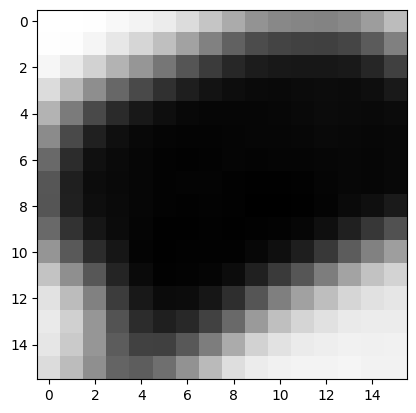

In [32]:
pixel_array = pydicom.pixels.pixel_array(header, decoding_plugin='pillow')
plt.imshow(pixel_array, cmap='gray')